In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("network.jl")
include("vsa.jl")
include("spiking.jl")

zero_nans (generic function with 1 method)

# Load the dataset

In [3]:
function getdata(args)
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

    @info "Getting and transforming data"

    ## Load dataset
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    ## Reshape input data to flatten each image into a linear array
    xtrain = Flux.flatten(xtrain)
    xtest = Flux.flatten(xtest)

    ## One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    ## Create two DataLoader objects (mini-batch iterators)
    train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize)

    return train_loader, test_loader
end

getdata (generic function with 1 method)

In [71]:
LayerNorm(1)

LayerNorm(1)        # 2 parameters

In [4]:
function build_model(; imgsize=(28,28,1), nclasses=10, nhidden::Int=128)
    return Chain( LayerNorm(1),
                  PhasorDense(prod(imgsize) => nhidden),
                  PhasorDense(nhidden => nclasses))
end

build_model (generic function with 1 method)

In [5]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [6]:
train_loader, test_loader = getdata(Args())

[ Info: Getting and transforming data


(DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=256), DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=256))

In [7]:
x, y = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 1 … 0 0; 0 0 … 0 1])

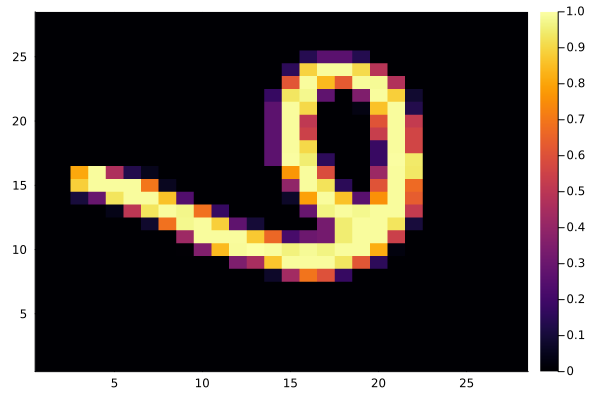

In [8]:
heatmap(reshape(x'[1,:], (28, 28)))

# Build the phasor model

In [9]:
phasor_model = build_model()

Chain(
  PhasorDense(784 => 128),              # 100_480 parameters
  PhasorDense(128 => 10),               # 1_290 parameters
)                   # Total: 4 arrays, 101_770 parameters, 398.328 KiB.

In [10]:
y_naive = phasor_model(x');

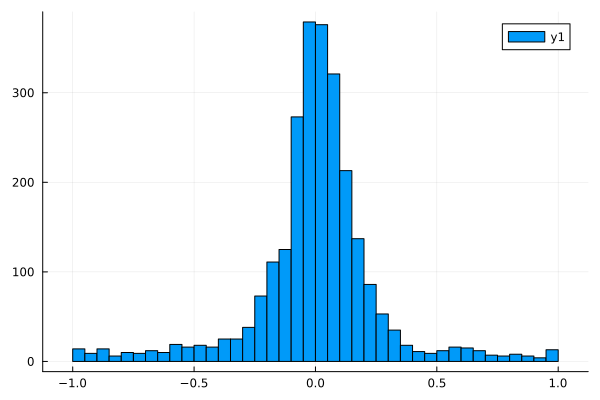

In [11]:
histogram(y_naive |> vec)

## test the correlation of static & dynamic phases

In [12]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [82]:
x_train = phase_to_train(x', spk_args, repeats = 5)

Spike Train: (256, 784) with 1003520 spikes.

In [83]:
x_call = SpikingCall(x_train, spk_args, (0.0, 10.0))

SpikingCall(Spike Train: (256, 784) with 1003520 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [15]:
y_spk_1 = phasor_model[1](x_call)

SpikingCall(Spike Train: (256, Base.OneTo(128)) with 281225 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [16]:
@time y_spk = phasor_model(x_call)

  4.190206 seconds (221.92 k allocations: 24.273 GiB, 18.01% gc time, 0.07% compilation time)


SpikingCall(Spike Train: (256, Base.OneTo(10)) with 24462 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [17]:
naive_spiking_phases = train_to_phase(y_spk);

In [18]:
cycle_correlation(y_naive, naive_spiking_phases)

10-element Vector{Float64}:
 0.2148959406063259
 0.46290670298914705
 0.5314800961948337
 0.4957599640903644
 0.4755207897785907
 0.45318501001990924
 0.44345182137425354
 0.4540792691997707
 0.45774982575045314
 0.44346616693734475

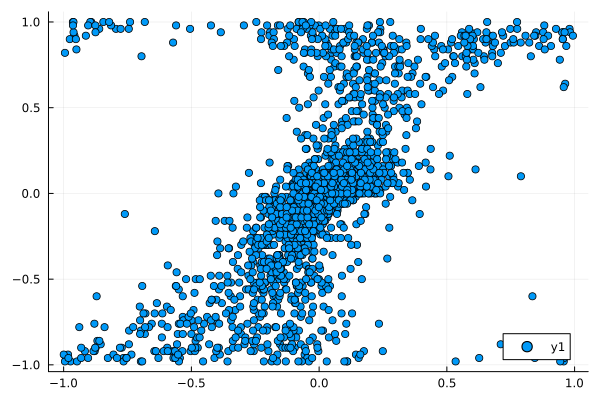

In [19]:
scatter(y_naive |> vec, naive_spiking_phases[3,:,:] |> vec)

## test the pre-train accuracy

In [20]:
mean(accuracy_quadrature(y_naive, y))

0.08984375

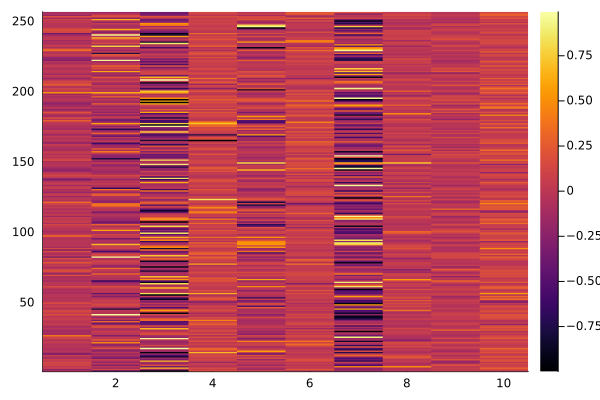

In [21]:
heatmap(y_naive)

In [22]:
function zero_nans(phases::AbstractArray)
    nans = isnan.(phases)
    phases[nans] .= 0.0
    return phases
end

zero_nans (generic function with 1 method)

In [23]:
zero_nans(naive_spiking_phases)

10×256×10 Array{Float64, 3}:
[:, :, 1] =
 -0.18  -0.2   0.0    0.0          …  -0.1   -0.04   0.0    0.0   -0.1
 -0.22  -0.26  0.02   0.04            -0.14  -0.12  -0.06  -0.04  -0.18
 -0.3   -0.28  0.1   -0.02            -0.14   0.0   -0.18  -0.08  -0.16
 -0.48  -0.32  0.2   -8.26006e-14     -0.18   0.02  -0.02  -0.1   -0.16
 -0.5   -0.34  0.22  -1.24345e-13     -0.2    0.06   0.0   -0.08  -0.16
 -0.52  -0.34  0.22  -1.66978e-13  …  -0.18   0.1    0.1   -0.08  -0.16
 -0.54  -0.34  0.22  -0.02            -0.18   0.12   0.26  -0.08  -0.14
 -0.56  -0.38  0.2   -0.02            -0.16   0.14   0.1   -0.08  -0.14
 -0.6   -0.42  0.18  -0.02            -0.16   0.12  -0.26  -0.08  -0.16
 -0.64  -0.48  0.16  -0.02            -0.16   0.1   -0.56  -0.08  -0.16

[:, :, 2] =
 -0.02  0.0   -0.02  -0.02   0.0   0.0   …  -0.04  -0.02  0.0   0.0   -0.1
 -0.2   0.02   0.0    0.0   -0.08  0.04     -0.2   -0.04  0.02  0.06  -0.12
 -0.86  0.16   0.98   0.04  -0.14  0.08     -0.2    0.98  0.74  0.82  -0.1
 

In [26]:
function loss_and_accuracy(data_loader, model, mode="static")
    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x')
        
        ls += sum(quadrature_loss(ŷ, y'))
        acc += sum(accuracy_quadrature(ŷ, y)) ## Decode the output of the model
        num +=  size(x)[end]
    end
    return ls / num, acc / num
end

loss_and_accuracy (generic function with 2 methods)

In [72]:
function accuracy(data_loader, model, spk_args::SpikingArgs, t_span::Tuple{<:Real, <:Real}; repeats::Int = 3)
    acc = []
    n_phases = []
    num = 0

    for (x, y) in data_loader
        train = phase_to_train(x', spk_args, repeats=repeats)
        call = SpikingCall(train, spk_args, t_span)
        spk_output = model(call)
        ŷ = train_to_phase(spk_output)
        
        append!(acc, sum.(accuracy_quadrature(ŷ, y))') ## Decode the output of the model
        num +=  size(x)[end]
    end

    return acc, num
end

accuracy (generic function with 1 method)

In [29]:
loss_and_accuracy(test_loader, phasor_model)

(0.3249945467883979, 0.0826)

In [30]:
right, num = accuracy(test_loader, phasor_model, spk_args, (0.0, 10.0))

(Any[25, 20, 26, 20, 29, 26, 24, 19, 17, 22  …  1, 1, 0, 1, 1, 2, 2, 3, 3, 3], 10000)

In [31]:
sum(reshape(right, 10, :), dims=2) ./ num

10×1 Matrix{Float64}:
 0.1114
 0.0971
 0.0923
 0.0983
 0.0965
 0.0953
 0.0956
 0.097
 0.097
 0.094

## Train the model

In [32]:
using Zygote: withgradient

In [33]:
function train(model; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    # if CUDA.functional() && args.use_cuda
    #     @info "Training on CUDA GPU"
    #     CUDA.allowscalar(false)
    #     device = gpu
    # else
        @info "Training on CPU"
        device = cpu
    # end

    ## Create test and train dataloaders
    train_loader, test_loader = getdata(args)

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt = Flux.setup(Adam(args.η), model)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        for (x, y) in train_loader
            x, y = transpose(device(x)), transpose(device(y)) ## transfer data to device
            loss, gs = withgradient(m -> mean(quadrature_loss(m(x), y)), model) ## compute gradient of the loss
            append!(losses, loss)
            Flux.Optimise.update!(opt, model, gs[1]) ## update parameters
        end

        ## Report on train and test
        train_loss, train_acc = loss_and_accuracy(train_loader, model)
        test_loss, test_acc = loss_and_accuracy(test_loader, model)
        println("Epoch=$epoch")
        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
    end

    return losses
end

train (generic function with 1 method)

In [34]:
opt = Flux.setup(Adam(3e-4), phasor_model)

(layers = ((weight = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))), (weight = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))))),)

In [35]:
l = train(phasor_model)

[ Info: Training on CPU
[ Info: Getting and transforming data
[ Info: Constructing model and starting training


Epoch=1
  train_loss = 0.042106722586582844, train_accuracy = 0.8267833333333333
  test_loss = 0.04176003621751625, test_accuracy = 0.8273
Epoch=2
  train_loss = 0.032607754619906476, train_accuracy = 0.87155
  test_loss = 0.0323264596770943, test_accuracy = 0.872
Epoch=3
  train_loss = 0.028223799497270427, train_accuracy = 0.8926666666666667
  test_loss = 0.02792970394414391, test_accuracy = 0.8949
Epoch=4
  train_loss = 0.02599454641638351, train_accuracy = 0.904
  test_loss = 0.02595051693253821, test_accuracy = 0.9051
Epoch=5
  train_loss = 0.024296828395169716, train_accuracy = 0.9125833333333333
  test_loss = 0.024600816196403627, test_accuracy = 0.9109
Epoch=6
  train_loss = 0.02233224226523683, train_accuracy = 0.9172
  test_loss = 0.022771714315010325, test_accuracy = 0.9155
Epoch=7
  train_loss = 0.020814520572989922, train_accuracy = 0.9256166666666666
  test_loss = 0.021254876799640412, test_accuracy = 0.922
Epoch=8
  train_loss = 0.020141432788545112, train_accuracy = 0.9

2350-element Vector{Any}:
 0.31485093714286266
 0.2127457606227997
 0.16522234238167663
 0.13178074941655532
 0.12292009073356203
 0.1184294489725804
 0.11332158041841751
 0.10907579298996224
 0.10704900797411841
 0.10596813331453256
 0.10566700264498993
 0.10415668622049025
 0.10278220341858912
 ⋮
 0.01798754546249913
 0.019350855591227657
 0.017360929951465646
 0.01790681547542864
 0.019033297166418016
 0.015869031235366902
 0.018633345511125617
 0.017123477851992357
 0.01751412443305393
 0.02016204290064172
 0.019515285829991305
 0.017713405754908925

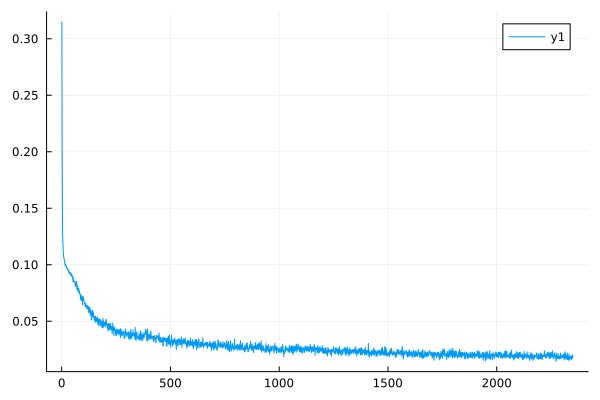

In [36]:
plot(l)

In [37]:
y_pred = phasor_model(x');

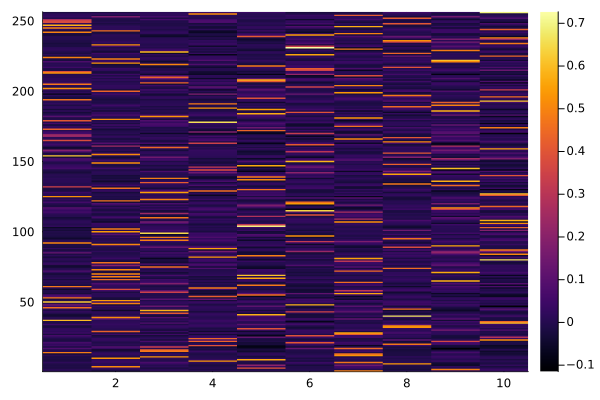

In [38]:
heatmap(y_pred)

In [39]:
y_layer1 = phasor_model[1](x');

In [84]:
y_layer1_spk = phasor_model[1](x_call)

SpikingCall(Spike Train: (256, Base.OneTo(128)) with 313330 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [85]:
y_spk = phasor_model(x_call)

SpikingCall(Spike Train: (256, Base.OneTo(10)) with 24200 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [86]:
y_layer1_phase = train_to_phase(y_layer1_spk);

In [87]:
y_phase = train_to_phase(y_spk);

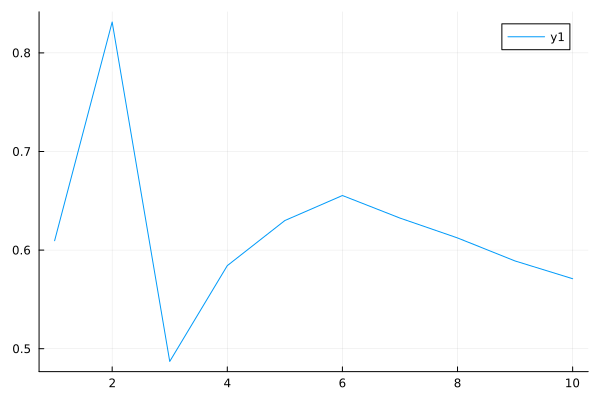

In [88]:
plot(cycle_correlation(y_layer1, y_layer1_phase))

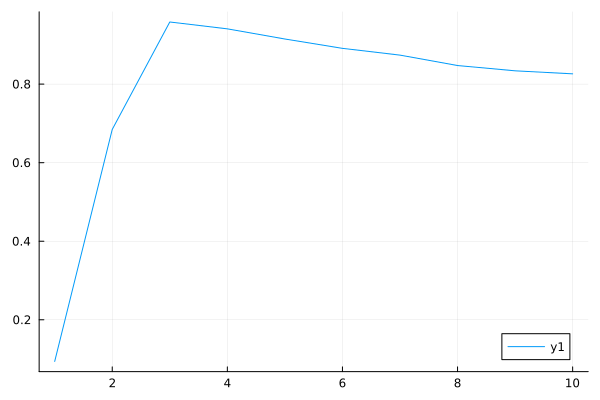

In [89]:
plot(cycle_correlation(y_pred, y_phase))

In [64]:
spk_accuracy =accuracy_quadrature(y_phase, y)

10-element Vector{BitMatrix}:
 [0; 0; … ; 0; 0;;]
 [0; 0; … ; 1; 0;;]
 [0; 1; … ; 1; 0;;]
 [1; 0; … ; 0; 1;;]
 [0; 1; … ; 1; 0;;]
 [0; 1; … ; 1; 1;;]
 [0; 1; … ; 1; 1;;]
 [1; 1; … ; 1; 1;;]
 [1; 1; … ; 1; 1;;]
 [0; 0; … ; 0; 0;;]

In [68]:
sum.(spk_accuracy)

10-element Vector{Int64}:
  71
  90
 192
  92
 149
 172
 194
 199
 183
  56

In [46]:
scatter(vec(y_layer1), vec(y_layer1_phase[3,:,:]))

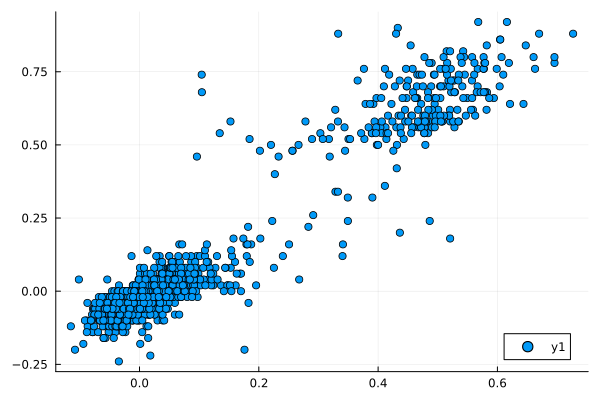

In [47]:
scatter(vec(y_pred), vec(y_phase[3,:,:]))

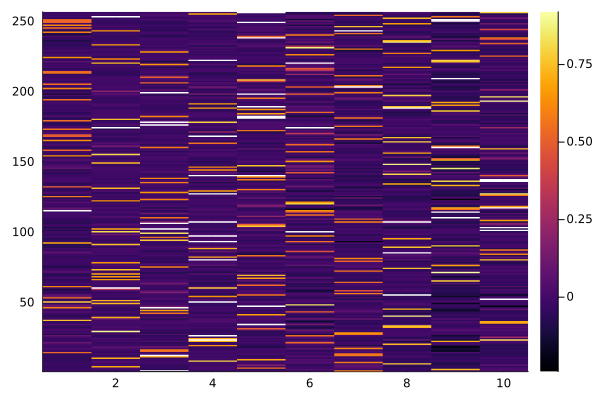

In [48]:
heatmap(y_phase[3,:,:])

In [49]:
loss_and_accuracy(test_loader, phasor_model)

(0.01877737776180729, 0.9332)

In [73]:
right, num = accuracy(test_loader, phasor_model, spk_args, (0.0, 10.0), repeats=5)

(Any[71, 91, 198, 130, 147, 129, 164, 187, 186, 61  …  5, 8, 12, 7, 8, 6, 8, 10, 10, 4], 10000)

In [74]:
right |> size

(400,)

In [75]:
reshape(right, 10, :)

10×40 Matrix{Any}:
  71   77   65   65   65   59   63   68  …   59   71   61   80   74   68   5
  91   78   90   91   81   90   89   87     117  108  108  109   76   68   8
 198  174  177  195  190  193  192  184     195  215  190  212  203  196  12
 130  118  118  123  116  123  117  122     111  123  121  133  124  112   7
 147  156  150  138  144  147  134  147     133  145  124  158  129  136   8
 129  118  119  120  118  133  128  125  …  132  118  111  147  133  131   6
 164  160  158  156  146  154  165  156     148  163  141  166  160  153   8
 187  167  178  174  161  181  163  173     165  181  165  190  174  162  10
 186  180  184  189  167  179  179  179     177  201  172  203  198  181  10
  61   51   60   64   60   57   57   72      59   51   55   53   69   52   4

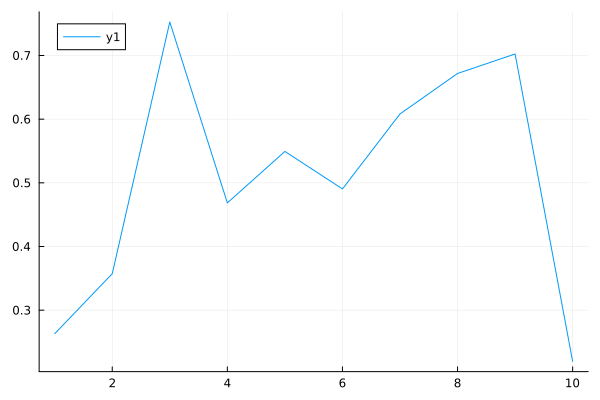

In [79]:
plot(sum(reshape(right, 10, :), dims=2) ./ num)